# Portfolio Optimization on the Efficient Frontier

## Data Extraction

We take a list of stocks and create a dataframe of each of their adjusted close data taken from Yahoo Finance given a certain training time period. In this project I have used data from 2016-2019 to find the optimal weights and I will test those weights on 2020 adjusted close data

In [382]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

stocks = ['NVDA', 'SQ', 'CHGG', 'ETSY', 'ENPH']
yahoodata = data.DataReader(stocks, 'yahoo', start='2016/01/01', end='2019/12/31')

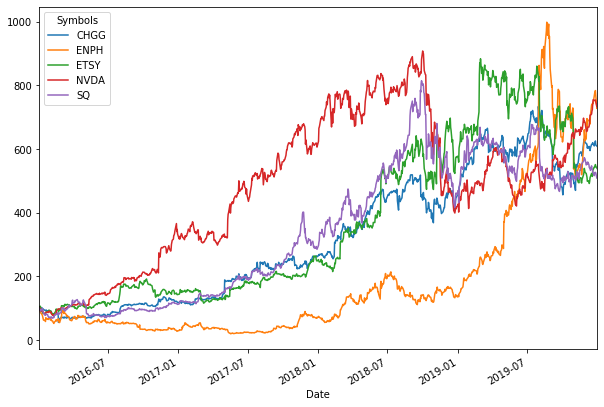

In [383]:
#takes the adjusted close of each stock
adjclose = yahoodata['Adj Close']
(adjclose/adjclose.iloc[0]*100).plot(figsize=(10, 7))

## Building the Efficient Frontier

First, we find the covariance of returns matrix to see how much each asset changes with respect to the others. Here we are using log returns to calculate percentage change. The reason for this is that log returns are time addative:

If R13 is the returns for time between t3 and t1.
   R12 is the returns between t1 and t2 and
   R23 is the returns between t2 and t3.

$$ ln(R13)) = ln(R12))+ln(R23)) $$


In [384]:
#covariance matrix
cov_matrix = adjclose.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix.head()

Symbols,CHGG,ENPH,ETSY,NVDA,SQ
Symbols,,,,,
CHGG,0.000866,0.000235,0.000309,0.000229,0.000284
ENPH,0.000235,0.002657,0.000326,0.000126,0.000361
ETSY,0.000309,0.000326,0.000994,0.000248,0.000354
NVDA,0.000229,0.000126,0.000248,0.000774,0.000359
SQ,0.000284,0.000361,0.000354,0.000359,0.000943


The covariance of an asset with itself is the variance of that asset. If the covariance between two assets is positive, then their is a positive correlation between the assets, and if the covariance is negative, there is a negative correlation. If the covariance is 0, then there is no correlation between the assets

To get yearly expected returns we "resample" the data to be yearly and take the average yearly percent change to get the yearly expected returns for each stock

In [385]:
#expected returns
ind_er = adjclose.resample('Y').last().pct_change().mean()
ind_er

Symbols
CHGG    0.762241
ENPH    2.291036
ETSY    0.664471
NVDA    0.427052
SQ      0.758943
dtype: float64

The following formulas will be used to calculate portfolio variance and expected portfolio return:

$$\sigma^2(R_p) =  \sum\sum w_i w_j COV(R_i, R_j) $$
$$ 𝐸(𝑅_𝑝)=𝑤_1𝐸(𝑅_1)+𝑤_2𝐸(𝑅_2)+…..𝑤_𝑛𝐸(𝑅_𝑛)$$

In the simulation, 10,000 portfolios of random weights are created. The portfolio variance and expected portfolio return are then calculated using the formula above. The portfolio variance is then converted to annual standard deviation which will be used as the volatility using the following formula:

$$ Volatility = \sigma_(yearly) = sqrt(\sigma^2(R_p)*250) $$

(250 for 250 trading days a year)

In [386]:

p_ret = [] #for portfolio returns
p_vol = [] #portfolio volatility
w = [] #asset weights

num_assets = len(adjclose.columns)
num_portfolios = 10000

for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    w.append(weights)
    
    #returns are the dot product between weights and expected returns
    returns = np.dot(weights, ind_er)   
    p_ret.append(returns)
    
    #portfolio variance calculated using cov matrix
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)#standard deviation is square root of variance
    
    #annual standard deviation = volatility
    ann_sd = sd*np.sqrt(250) #250 trading days/year.
    p_vol.append(ann_sd)
    


Each portfolio is then plotted on an expected volatility and expected return plot:

Text(0.5, 1.0, 'Efficient Frontier Plot')

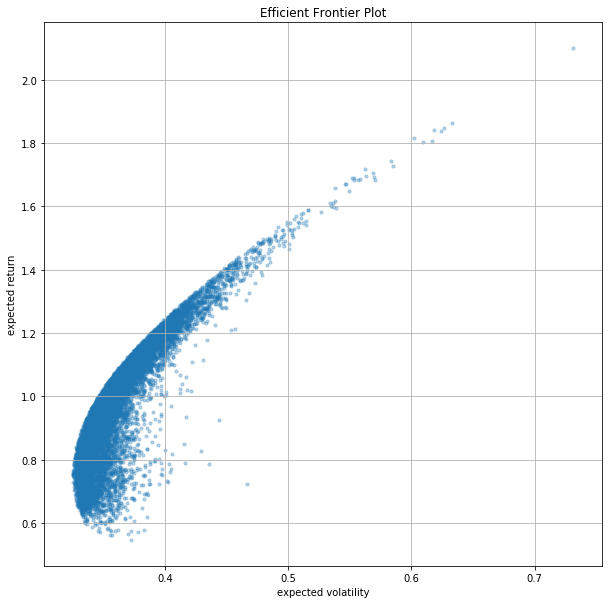

In [387]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(adjclose.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in w]

portfolios  = pd.DataFrame(data)
portfolios.head() #10000 portfolios created

#efficient frontier plot
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.title('Efficient Frontier Plot')

The minimum volatility portfolio is found by taking the weights of the portfolio witht he least volatility and is marked with a red star on the plot:

In [388]:
print("Minimum Volatility Portfolio:")
# idxmin() gives us the minimum value in the column specified.
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
min_vol_port

Minimum Volatility Portfolio:


Returns        0.754240
Volatility     0.325019
CHGG weight    0.283096
ENPH weight    0.074143
ETSY weight    0.182235
NVDA weight    0.307373
SQ weight      0.153153
Name: 6640, dtype: float64

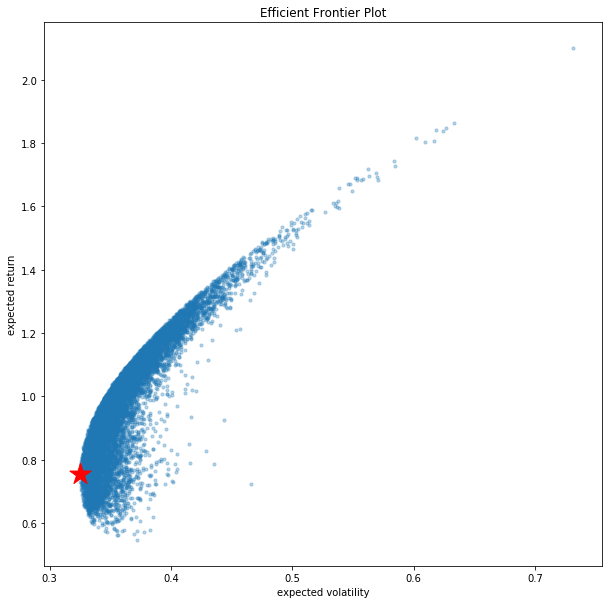

In [389]:
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.title('Efficient Frontier Plot')
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

The optimnal risky portfolio is defined as the phone with the highest sharpe ratio:
$$ Sharpe Ratio = (R_p - R_f) /\sigma_p $$

R_f is the risk factor that is made to be .01 in this scenario
The portfolio witht he highest Sharpe Ratio is where the slope of the tangent line to the efficient frontier curve is the highest. This means we would achieve the highest return per unit of risk with that portfolio. 
The optimal risky portfolio is returned and is marked with a green star on the plot:

In [390]:
print("Optimal Risky Portfolio:")
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Optimal Risky Portfolio:


Returns        1.405088
Volatility     0.447522
CHGG weight    0.271537
ENPH weight    0.442177
ETSY weight    0.057243
NVDA weight    0.080745
SQ weight      0.148298
Name: 3546, dtype: float64

Text(0.5, 1.0, 'Efficient Frontier Plot')

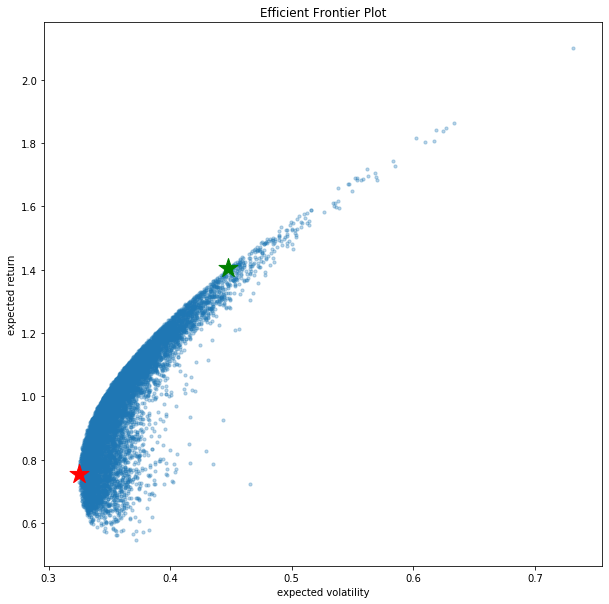

In [391]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=400)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=400)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.title('Efficient Frontier Plot')

## Backtesting

Since 2016-2019 adjusted close data was used to find the optimal weights, 2020 adjusted close data is used to test the performance of the weights. While 2020 was a very unusual year in the markets, we can still see how the optimal risky portfolio still outperformed the portfolio with equal weights and the S&P 500 benchmark. 

To do this, the dot product of the 2020 adjusted close data and the weights of a certain portfolio is taken and then scaled so the first value is 100. The dataframe values are then shifted down 100 but subtracting to show percentage return for each portfolio:

In [405]:
from pandas_datareader import data
#creates an array for cumulated % returns for minimum volatility portfolio
w = min_vol_port[2:7].to_numpy()
data_2020 = data.DataReader(stocks, 'yahoo', start='2020/01/01', end='2020/12/31')['Adj Close']
data_2020.to_numpy()
preturns = np.dot(data_2020,w)
min_v_preturns_df = pd.DataFrame(preturns, columns = ['Minimum Volatility Portfolio Returns (%)'])
min_v_preturns_df = min_v_preturns_df.div(min_v_preturns_df.iloc(0)[0]/100, axis = 1)#to scale
min_v_preturns_df = min_v_preturns_df.subtract(100)#to start at 0

#creates an array for cumulated % returns for optimal risky portfolio
w = optimal_risky_port[2:7].to_numpy()
preturns = np.dot(data_2020,w)
optimal_risky_preturns_df = pd.DataFrame(preturns, columns = ['Optimal Risky Portfolio Returns (%)'])
optimal_risky_preturns_df = optimal_risky_preturns_df.div(optimal_risky_preturns_df.iloc(0)[0]/100, axis = 1)#to scale
optimal_risky_preturns_df = optimal_risky_preturns_df.subtract(100)#to start at 0

#creates an array for cumulated % returns for equal weight portfolio
w = np.full((len(adjclose.columns), 1), 1/len(adjclose.columns))
preturns = np.dot(data_2020,w)
equal_weight_preturns_df = pd.DataFrame(preturns, columns = ['Equal Weight Portfolio Returns (%)'])
equal_weight_preturns_df = equal_weight_preturns_df.div(equal_weight_preturns_df.iloc(0)[0]/100, axis = 1)#to scale
equal_weight_preturns_df = equal_weight_preturns_df.subtract(100)#to start at 0

In [406]:
#creates an array for cumulated % returns for the S&P
sp = data.DataReader('^GSPC', 'yahoo', start='2020/01/01', end='2020/12/31')['Adj Close']
scaled_sp = sp.div(sp.iloc(0)[0]/100)
scaled_sp = scaled_sp.subtract(100)
scaled_sp.columns=['S&P']
scaled_sp.reset_index(level=None, drop=True, inplace=True)

#creates an array for cumulated % returns for the NASDAQ
q = data.DataReader('^IXIC', 'yahoo', start='2020/01/01', end='2020/12/31')['Adj Close']
scaled_q = q.div(q.iloc(0)[0]/100)
scaled_q = scaled_q.subtract(100)
scaled_q.columns=['NASQAQ']
scaled_q.reset_index(level=None, drop=True, inplace=True)

#creates an array for cumulated % returns for the S&P
dow = data.DataReader('^DJI', 'yahoo', start='2020/01/01', end='2020/12/31')['Adj Close']
scaled_dow = dow.div(dow.iloc(0)[0]/100)
scaled_dow = scaled_dow.subtract(100)
scaled_dow.columns=['Dow Jones Industrial Average']
scaled_dow.reset_index(level=None, drop=True, inplace=True)

Minimum Volatility Portfolio Returns (%)    149.723615
Name: 250, dtype: float64
Equal Weight Portfolio Returns (%)    180.032769
Name: 250, dtype: float64
Optimal Risky Portfolio Returns (%)    232.891497
Name: 250, dtype: float64


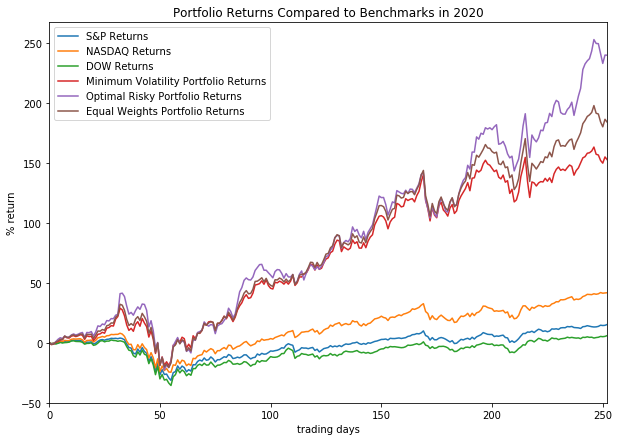

In [407]:
scaled_spy.reset_index(drop=True, inplace=True)
min_v_preturns_df.reset_index(drop=True, inplace=True)
alldata = pd.concat([scaled_sp,scaled_q,scaled_dow,min_v_preturns_df,optimal_risky_preturns_df,equal_weight_preturns_df],axis=1,ignore_index=True)
alldata.columns =['S&P Returns','NASDAQ Returns','DOW Returns','Minimum Volatility Portfolio Returns','Optimal Risky Portfolio Returns','Equal Weights Portfolio Returns']

alldata.plot(figsize=(10, 7))
plt.title('Portfolio Returns Compared to Benchmarks in 2020')
plt.xlabel('trading days')
plt.ylabel('% return')
print((min_v_preturns_df.iloc(0)[250]))
print((equal_weight_preturns_df.iloc(0)[250]))
print((optimal_risky_preturns_df.iloc(0)[250]))

The graph above shows that the optimal risky portfolio drastically outperformed the equal weight and minimum volatility portfolio, especially in the end of the year. The 2020 return for the optimal risky portfolio was 232.891497%. The 2020 return for the equal weight portfolio was 180.032769% and the 2020 return for the minimum volatility portfolio was 149.723615%. All three portfolios outperformed each of the 3 benchmarks: S%P, NASDAQ, and DOW